# Problem Set 4, due October 22 at 11:59pm

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions (especially the sections on vectorized computation and computational efficiency).
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names).

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import time

In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

> <font color='red'>Convert into a dataframe:</font>

In [3]:
boston = pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names[:]
boston['MEDV'] = bdata.target

In [4]:
print(bdata.feature_names[:])

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


---

## Part 1: Getting oriented


### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  Interpret your results.

> <font color='red'>The two fits we are trying to achieve are just linear and quadratic fits:
>
> $$
Y = \alpha + x_{1}X 
$$
>
> $$
Y = \alpha + x_{1}X^{2} + x_{2}X
$$
></font>

A: Y = aX + b
a = 9.10, b = -34.67
mean squared error = 43.60
---
B: Y = aX^2 + bX + c
a = 2.47, b = -22.64, c = 66.06
mean squared error = 38.12


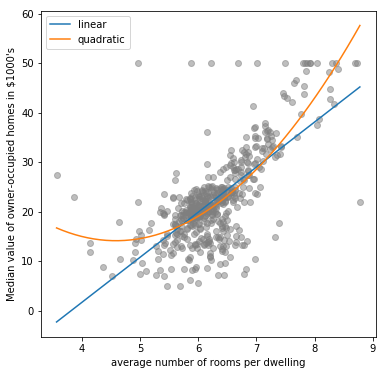

In [5]:
# pull out X and Y
X = boston[['RM']].values.copy()
Y = boston['MEDV'].values.copy()

# create an array for [X^2, X]
X_2 = np.append(X**2, X, 1)

# create the X arrays for feeding into OLS
OLS_X = sm.add_constant(X)
OLS_X_2 = sm.add_constant(X_2)

# linear regressions
model_1 = sm.OLS(Y,OLS_X)
model_2 = sm.OLS(Y,OLS_X_2)
results_1 = model_1.fit()
results_2 = model_2.fit()

# use the coefficients to make predictions
Y_1 = results_1.predict(OLS_X)
Y_2 = results_2.predict(OLS_X_2)

# for plotting
X_plot = np.linspace(np.min(X), np.max(X))
Y_1_plot = results_1.params[0] + results_1.params[1]*X_plot
Y_2_plot = results_2.params[0] + results_2.params[1]*X_plot**2 + results_2.params[2]*X_plot

# print statistics
print('A: Y = aX + b')
print('a = {:.2f}, b = {:.2f}'.format(results_1.params[1], results_1.params[0]))
print('mean squared error = {:.2f}'.format(mean_squared_error(Y, Y_1)))
print('---')
print('B: Y = aX^2 + bX + c')
print('a = {:.2f}, b = {:.2f}, c = {:.2f}'.format(results_2.params[1], results_2.params[2],results_2.params[0]))
print('mean squared error = {:.2f}'.format(mean_squared_error(Y, Y_2)))

# set up plot
fig, ax = plt.subplots(figsize=(6,6))

# plot
ax.scatter(X, Y, alpha=0.5, c='C7')
ax.plot(X_plot, Y_1_plot, c='C0', label='linear')
ax.plot(X_plot, Y_2_plot, c='C1', label='quadratic')
ax.set_xlabel('average number of rooms per dwelling')
ax.set_ylabel("Median value of owner-occupied homes in $1000's")
ax.legend()

plt.show(fig)

> <font color='red'>As we can see from the plot above, `MEDV` is not predicted particularly well with `RM` in a linear or quadratic regression. In the linear regression case, the coefficient can be interpreted easily: for every extra room, `MEDV` increases on average by 9.10. The intercept is physically meaningless in this case, since no house has zero rooms. In the quadratic regression case, the coefficients cannot be interpreted directly, other than to say that for every extra room, `MEDV` increases on average by $2.47 X^{2} - 22.64 X$, where $X$ is `RM`.
>
> We can further see that, at least from a least squares perspective, the quadratic fit (MSE = 38.12) performs slightly better than the linear fit (MSE = 43.60).</font>

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 25-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the 25 slope coefficients using a histogram, then draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you notice?

slope coefficient from 1.1          = 9.10211
mean of slope coefficients from 1.2 = 9.10181


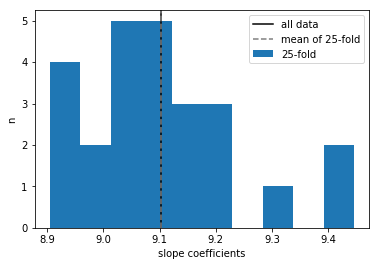

In [6]:
# set up the 25-fold cross validation, with a seed
n_splits = 25
kf = KFold(n_splits=n_splits, shuffle=True, random_state=22)

# get the training and testing indexes
train_inds = []
test_inds = []
for train_ind, test_ind in kf.split(X):
    train_inds.append(train_ind)
    test_inds.append(test_ind)
    
# do the regression
coeffs = np.zeros(n_splits)
for i in range(n_splits):
    reg = LinearRegression().fit(X[train_inds[i]], Y[train_inds[i]])
    coeffs[i] = reg.coef_[0]
    
# print some numbers
print('slope coefficient from 1.1          = {:.5f}'.format(results_1.params[1]))
print('mean of slope coefficients from 1.2 = {:.5f}'.format(np.mean(coeffs)))
    
# plot
fig, ax = plt.subplots()

ax.hist(coeffs, label='25-fold')
ax.axvline(results_1.params[1], c='k', label='all data')
ax.axvline(np.mean(coeffs), c='C7', ls='--', label='mean of 25-fold')
ax.set_xlabel('slope coefficients')
ax.set_ylabel('n')
ax.legend()

plt.show(fig)

> <font color='red'>As expected, the 25-fold cross-validation produces a range of slope coefficients. Interestingly, however, the slope coefficient obtained from using all the data in part 1.1 is almost exactly the mean of the slope coefficients obtained using the 25-fold cross-validation. This can qualitatively be explained by the fact that taking the mean of a series of regressions to several randomly selected subsets of the data is effectively identical to regressing the entire dataset once.</font>

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

Note: You can get 2 points even without the confidence bands (if the other lines are correct, the axes are labeled, the lines are labeled, the points are plotted correctly, and so forth). If you do everything perfectly including the confidence bands, you get 2 points. If you do something else wrong and would normally receive less than two points, the confidence intervals can replace lost points up to 0.5.

Useful reference: [1](https://www.medcalc.org/manual/scatter_diagram_regression_line.php), [2](https://rpubs.com/aaronsc32/regression-confidence-prediction-intervals)

You can directly use some packages to calculate the bands.

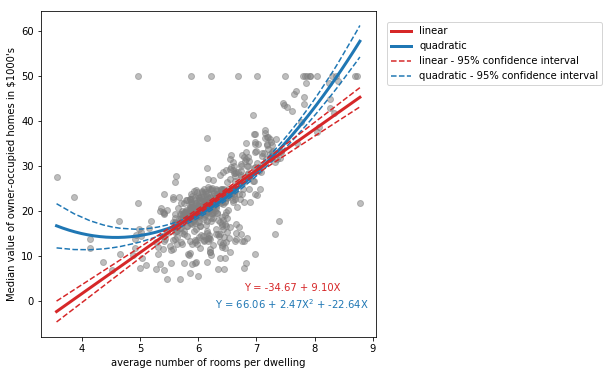

In [7]:
# use summary_table to get the confidence intervals
st_1, data_1, ss2_1 = summary_table(results_1, alpha=0.05)
st_2, data_2, ss2_2 = summary_table(results_2, alpha=0.05)
ci_low_1, ci_upp_1 = data_1[:,4:6].T
ci_low_2, ci_upp_2 = data_2[:,4:6].T

# sort X for plotting
X_sortargs = np.argsort(boston['RM'].values)

# set up plot
fig, ax = plt.subplots(figsize=(6,6))

# plot data
ax.scatter(X, Y, alpha=0.5, c='C7')

# plot regression
ax.plot(X_plot, Y_1_plot, c='C3', lw=3, label='linear', zorder=2)
ax.plot(X_plot, Y_2_plot, c='C0', lw=3, label='quadratic', zorder=1)

# the confidence intervals
ax.plot(X[X_sortargs], ci_low_1[X_sortargs], ls='--', c='C3', zorder=2, label='linear - 95% confidence interval')
ax.plot(X[X_sortargs], ci_upp_1[X_sortargs], ls='--', c='C3', zorder=2, label='__nolegend__')
ax.plot(X[X_sortargs], ci_low_2[X_sortargs], ls='--', c='C0', zorder=1, label='quadratic - 95% confidence interval')
ax.plot(X[X_sortargs], ci_upp_2[X_sortargs], ls='--', c='C0', zorder=1, label='__nolegend__')

# write equation
ax.text(0.75, 0.15,
        'Y = {:.2f} + {:.2f}X'.format(results_1.params[0], results_1.params[1]),
        horizontalalignment='center',verticalalignment='center',transform=ax.transAxes,color='C3')
ax.text(0.75, 0.10,
        'Y = {:.2f} + {:.2f}X$^2$ + {:.2f}X'.format(results_2.params[0], results_2.params[1], results_2.params[2]),
        horizontalalignment='center',verticalalignment='center',transform=ax.transAxes,color='C0')

# prettify
ax.set_xlabel('average number of rooms per dwelling')
ax.set_ylabel("Median value of owner-occupied homes in $1000's")
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 0.98))

plt.show(fig)

## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds
* How do your coefficients compare to the ones estimated through standard libraries? Does this depend on *R*?

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: Some people like to include a MaxIts parameter in their gradient descent algorithm, to prevent divergence.*

> <font color='red'>The linear regression equation:
>
> $$
Y = \alpha + \beta X 
$$
>
> The cost function is:
>
>$$
J(\alpha,\beta) = \frac{1}{2N}\sum^{N}_{i=1}(\alpha + \beta X_{i} - Y_{i})^{2}
$$
> 
> The associated gradient descent algorithm for each iteration is:
>
> $$
\alpha_{new} = \alpha - R \frac{1}{N}\sum^{N}_{i=1}(\alpha + \beta X_{i} - Y_{i})
$$
>
> $$
\beta_{new} = \beta - R \frac{1}{N}\sum^{N}_{i=1}(\alpha + \beta X_{i} - Y_{i})X_{i}
$$
>
> The stopping criteria that I select is to check if $\alpha$ and $\beta$ are close to the estimates from the previous iteration.</font>

In [8]:
def bivariate_ols(xvalues, yvalues, alpha_i, beta_i, R, epsilon, MaxIts):
    """
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

    Parameters
    ----------
    xvalues : narray - ROW VECTOR
        independent variable
        
    yvalues : narray - ROW VECTOR
        dependent variable
        
    alpha_i : float
        initial alpha
        
    beta_i : float
        initial beta

    R : float
        Learning rate
        
    epsilon : float
        Convergence threshold

    MaxIts : Int
        maximum number of iterations

    Returns
    -------
    alpha : float
        intercept

    beta : float
        coefficient
        
    alphas : array
        each alpha that was stepped through
        
    betas : array
        each beta that was stepped through
        
    total_time : float
        running time in seconds
        
    iterations : int
        number of iterations to achieve convergence
    """
    # start the stopwatch
    start_time = time.time()
    
    # storage vectors
    alphas = np.array([alpha_i])
    betas = np.array([beta_i])
    
    # initialize coefficients
    alpha = alpha_i
    beta = beta_i
    N = len(yvalues)
    
    # loop until the max iterations
    for i in range(MaxIts):
        
        # compute new coefficients
        new_alpha = alpha - ((R/N) * np.sum(alpha + beta*xvalues - yvalues))
        new_beta = beta - ((R/N) * np.sum((alpha + beta*xvalues - yvalues)*xvalues))
        
        # store
        alphas = np.append(alphas, new_alpha)
        betas = np.append(betas, new_beta)
        
        # check to see whether stopping criteria has been met
        if (np.abs(new_alpha-alpha)<epsilon) and (np.abs(new_beta-beta)<epsilon):
            alpha = new_alpha
            beta = new_beta
            break
        else:
            alpha = new_alpha
            beta = new_beta
    
    # iterations - print warning message if max iterations reached
    iterations = i+1
    if iterations==MaxIts:
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print('!!! max iterations reached !!!')
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

    # stop the stopwatch
    end_time = time.time()
    total_time = end_time - start_time
    
    return alpha, beta, alphas, betas, total_time, iterations

> <font color='red'>Do the gradient descent for  4 Rs:</font>

In [9]:
# pull out X and Y
X = boston['RM'].values.copy()
Y = boston['MEDV'].values.copy()

# initial alpha, beta
alpha_i = -30
beta_i = 5

# try R = 1e-2
alpha_1, beta_1, alphas_1, betas_1, total_time, iterations = bivariate_ols(X, Y, alpha_i, beta_i,
                                                                           R=1e-2, epsilon=1e-4, MaxIts=100000)
print('R = 1e-2')
print('alpha      = {:.2f}'.format(alpha_1))
print('beta       = {:.2f}'.format(beta_1))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# try R = 1e-3
alpha_2, beta_2, alphas_2, betas_2, total_time, iterations = bivariate_ols(X, Y, alpha_i, beta_i,
                                                                           R=1e-3, epsilon=1e-4, MaxIts=100000)
print('R = 1e-3')
print('alpha      = {:.2f}'.format(alpha_2))
print('beta       = {:.2f}'.format(beta_2))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# try R = 1e-4
alpha_3, beta_3, alphas_3, betas_3, total_time, iterations = bivariate_ols(X, Y, alpha_i, beta_i,
                                                                           R=1e-4, epsilon=1e-4, MaxIts=100000)
print('R = 1e-4')
print('alpha      = {:.2f}'.format(alpha_3))
print('beta       = {:.2f}'.format(beta_3))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# try R = 1e-5
alpha_4, beta_4, alphas_4, betas_4, total_time, iterations = bivariate_ols(X, Y, alpha_i, beta_i,
                                                                           R=1e-5, epsilon=1e-4, MaxIts=100000)
print('R = 1e-5')
print('alpha      = {:.2f}'.format(alpha_4))
print('beta       = {:.2f}'.format(beta_4))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))

R = 1e-2
alpha      = -33.84
beta       = 8.97
time       = 0.57s
iterations = 15225

R = 1e-3
alpha      = -29.49
beta       = 8.29
time       = 0.01s
iterations = 176

R = 1e-4
alpha      = -29.49
beta       = 8.26
time       = 0.04s
iterations = 1198

R = 1e-5
alpha      = -29.53
beta       = 8.04
time       = 0.21s
iterations = 6348


> <font color='red'>Plot how the cost function is changing with each iteration:</font>

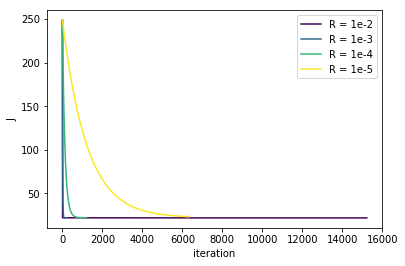

In [10]:
# the bivariate cost function
def bivariate_cost(xvalues, yvalues, alphas, betas):
    
    costs = np.zeros(len(alphas))
    
    for i in range(len(alphas)):
        cost = (1/(2*len(yvalues))) * np.sum((alphas[i] + betas[i]*xvalues -yvalues)**2)
        costs[i] = cost
    
    return costs

# plot cost function
fig, ax = plt.subplots()

# colormap
colors = plt.cm.viridis(np.linspace(0,1,4))

ax.plot(np.arange(len(alphas_1)), bivariate_cost(X, Y, alphas_1, betas_1), c=colors[0], label='R = 1e-2')
ax.plot(np.arange(len(alphas_2)), bivariate_cost(X, Y, alphas_2, betas_2), c=colors[1], label='R = 1e-3')
ax.plot(np.arange(len(alphas_3)), bivariate_cost(X, Y, alphas_3, betas_3), c=colors[2], label='R = 1e-4')
ax.plot(np.arange(len(alphas_4)), bivariate_cost(X, Y, alphas_4, betas_4), c=colors[3], label='R = 1e-5')
ax.legend()
ax.set_ylabel('J')
ax.set_xlabel('iteration')

plt.show(fig)

> <font color='red'>Plot how the $\alpha$ and $\beta$ are changing with each iteration:</font>

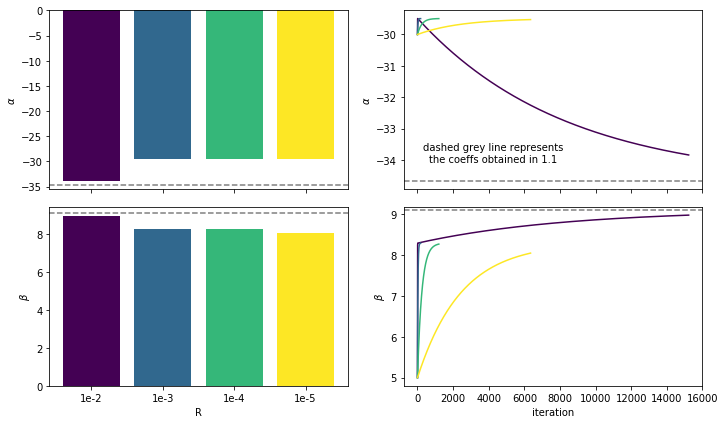

In [11]:
# plot
fig, ax = plt.subplots(nrows=2, ncols=2, sharex='col', figsize=(10,6))

ax = ax.flatten()

# alpha
ax[0].bar(np.arange(4), [alpha_1, alpha_2, alpha_3, alpha_4], color=colors)
ax[0].axhline(results_1.params[0], ls='--', c='C7')
ax[0].set_ylabel('$\\alpha$')

ax[1].plot(np.arange(len(alphas_1)), alphas_1, c=colors[0])
ax[1].plot(np.arange(len(alphas_2)), alphas_2, c=colors[1])
ax[1].plot(np.arange(len(alphas_3)), alphas_3, c=colors[2])
ax[1].plot(np.arange(len(alphas_4)), alphas_4, c=colors[3])
ax[1].axhline(results_1.params[0], ls='--', c='C7')
ax[1].set_ylabel('$\\alpha$')
ax[1].text(0.3,0.2,'dashed grey line represents\nthe coeffs obtained in 1.1',
           horizontalalignment='center',verticalalignment='center',transform=ax[1].transAxes)

# beta
ax[2].bar(np.arange(4), [beta_1, beta_2, beta_3, beta_4], color=colors)
ax[2].axhline(results_1.params[1], ls='--', c='C7')
ax[2].set_ylabel('$\\beta$')
ax[2].set_xticks(np.arange(4))
ax[2].set_xticklabels(['1e-2','1e-3','1e-4','1e-5'])
ax[2].set_xlabel('R')

ax[3].plot(np.arange(len(betas_1)), betas_1, c=colors[0])
ax[3].plot(np.arange(len(betas_2)), betas_2, c=colors[1])
ax[3].plot(np.arange(len(betas_3)), betas_3, c=colors[2])
ax[3].plot(np.arange(len(betas_4)), betas_4, c=colors[3])
ax[3].axhline(results_1.params[1], ls='--', c='C7')
ax[3].set_ylabel('$\\beta$')
ax[3].set_xlabel('iteration')

fig.tight_layout()
plt.show(fig)

> <font color='red'>I selected four R's to test, as can be seen from the text and plots above. In all cases, the gradient descent met the stopping criteria ($\epsilon$ of 1e-4 for both $\alpha$ and $\beta$) before the maximum iteration count was reached. I ended up testing multiple combinations of initial $\alpha$ and $\beta$, R, and $\epsilon$, but only show results for one initial $\alpha$ and $\beta$ and $\epsilon$ that exhibits approximately representative behaviour of the tested combinations.
>
> With an initial $\alpha$ of -30 and an initial $\beta$ of 5 (values that are near the values obtained in part 1), we see that the gradient descent outputs coefficients that are similar to those obtained in part 1. However, the way in which the gradient descent reaches its final values is different for $\alpha$ and $\beta$. For $\beta$, all iterations increase $\beta$ toward the value obtained in part 1. However, none of the models actually end up reaching this value. This is because our stopping criteria is actually dependent on R - as R decreases, the size of each step decreases, and thus we more quickly reach our stopping criteria even though the model hasn't reached the true minimum of the loss function. Thus, we see that R = 1e-2 gets very close to the $\beta$ obtained in part 1 before stopping, but with decreasing R the estimated $\beta$ gets further and further away from the value obtained in part 1.
>
> $\alpha$ actually initially increases in all gradient descent models, away from the $\alpha$ obtained in part 1. With R = 1e-2, the model is able to move past the inflexion, and starts decreasing and moving closer to the value obtained in part 1. All other models, however, fail to reach the inflexion for the reasons described above - the step size becomes small enough to meet the stopping criteria.
>
> This interplay between the stopping criteria and R is noteworthy, because it illustrates that the model may stop at at a point before the gradient of the loss function actually reaches zero (in other words, if we were to visualize a parabolic gravity well, the ball may stop at a gravitationally infeasible location on the slopes of the well at some significant distance above the bottom).</font>

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [12]:
def standardize(raw_data):
    """
    Standardize data.
    
    Parameters
    ----------
    raw_data : narray
        data

    Returns
    -------
    normalized : array
        normalized data
    """
    normalized = ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))
    
    return normalized

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

> <font color='red'>The linear regression equation:
>
> $$
Y = \alpha + \beta_{1}X_{1} + ... +  \beta_{k}X_{k}
$$
>
> The cost function is:
>
>$$
J(\alpha, \beta_{1}, ..., \beta_{k}) = \frac{1}{2N}\sum^{N}_{i=1}(\alpha + \beta_{1}X_{i1} + ... + \beta_{k}X_{ik} - Y_{i})^{2}
$$
> 
> The associated gradient descent algorithm for each iteration is:
>
> $$
\alpha_{new} = \alpha - R \frac{1}{N}\sum^{N}_{i=1}(\alpha + \beta_{1}X_{i1} + ... + \beta_{k}X_{ik} - Y_{i})
$$
>
> $$
\beta_{j-new} = \beta_{j} - R \frac{1}{N}\sum^{N}_{i=1}(\alpha + \beta_{1}X_{i1} + ... + \beta_{k}X_{ik} - Y_{i})X_{ij}
$$
>
> The stopping criteria that I select is to check if $\alpha$ and $\beta_{j}$ are close to the estimates from the previous iteration.</font>

In [13]:
def multivariate_ols(xvalues, yvalues, alpha_i, betas_i, R, epsilon, MaxIts):
    """
    Gradient Decent to minimize OLS. Used to find co-efficients of multivariate OLS Linear regression

    Parameters
    ----------
    xvalues : narray - COLUMN VECTOR
        independent variable
        
    yvalues : narray - ROW VECTOR
        dependent variable
        
    alpha_i : float
        initial alpha
        
    beta_i : array - ROW VECTOR
        initial betas

    R : float
        Learning rate
        
    epsilon : float
        Convergence threshold

    MaxIts : Int
        maximum number of iterations

    Returns
    -------
    alpha : float
        intercept

    beta : array
        coefficients
        
    alphas : array
        each alpha that was stepped through
        
    betas : array
        each beta that was stepped through
        
    total_time : float
        running time in seconds
        
    iterations : int
        number of iterations to achieve convergence
    """
    # start the stopwatch
    start_time = time.time()
    
    # storage vectors
    alphas = np.array([alpha_i])
    betas = np.array([beta_i])
    
    # initialize coefficients
    alpha = alpha_i
    beta = beta_i
    N = len(yvalues)
    
    # loop until the max iterations
    for i in range(MaxIts):
        
        # compute new coefficients
        new_alpha = alpha - ((R/N) * np.sum(alpha + np.sum(beta*xvalues, axis=1) - yvalues))
        new_beta = beta - ((R/N) * np.sum((alpha + np.sum(beta*xvalues, axis=1) - yvalues)*(xvalues.T), axis=1))
        
        # store
        alphas = np.append(alphas, new_alpha)
        betas = np.append(betas, np.array([new_beta]), axis=0)
        
        # check to see whether stopping criteria has been met
        if (np.abs(new_alpha-alpha)<epsilon) and np.all(np.abs(new_beta-beta)<epsilon):
            alpha = new_alpha
            beta = new_beta
            break
        else:
            alpha = new_alpha
            beta = new_beta
    
    # iterations - print warning message if max iterations reached
    iterations = i+1
    if iterations==MaxIts:
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print('!!! max iterations reached !!!')
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

    # stop the stopwatch
    end_time = time.time()
    total_time = end_time - start_time
    
    return alpha, beta, alphas, betas, total_time, iterations

> <font color='red'>Do the gradient descent for  3 Rs:</font>

In [14]:
# pull out X and Y
X = standardize(boston[['CRIM','RM']].values.copy())
Y = boston['MEDV'].values.copy()

# initial alpha, beta
alpha_i = 0
beta_i = np.array([0,0])

# try R = 1e-1
alpha_1, beta_1, alphas_1, betas_1, total_time, iterations = multivariate_ols(X, Y, alpha_i, beta_i,
                                                                              R=1e-1, epsilon=1e-5,
                                                                              MaxIts=100000)
print('R = 1e-1')
print('alpha      = {:.2f}'.format(alpha_1))
print('beta       = {:.2f}, {:.2f}'.format(beta_1[0], beta_1[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# try R = 1e-2
alpha_2, beta_2, alphas_2, betas_2, total_time, iterations = multivariate_ols(X, Y, alpha_i, beta_i,
                                                                              R=1e-2, epsilon=1e-5,
                                                                              MaxIts=100000)
print('R = 1e-2')
print('alpha      = {:.2f}'.format(alpha_2))
print('beta       = {:.2f}, {:.2f}'.format(beta_2[0], beta_2[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# try R = 1e-3
alpha_3, beta_3, alphas_3, betas_3, total_time, iterations = multivariate_ols(X, Y, alpha_i, beta_i,
                                                                              R=1e-3, epsilon=1e-5,
                                                                              MaxIts=100000)
print('R = 1e-3')
print('alpha      = {:.2f}'.format(alpha_3))
print('beta       = {:.2f}, {:.2f}'.format(beta_3[0], beta_3[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

R = 1e-1
alpha      = 22.53
beta       = -2.28, 5.89
time       = 0.01s
iterations = 119

R = 1e-2
alpha      = 22.53
beta       = -2.28, 5.89
time       = 0.08s
iterations = 999

R = 1e-3
alpha      = 22.52
beta       = -2.28, 5.89
time       = 0.63s
iterations = 7718



> <font color='red'>Plot how the cost function, $\alpha$, and $\beta$ are changing with each iteration:</font>

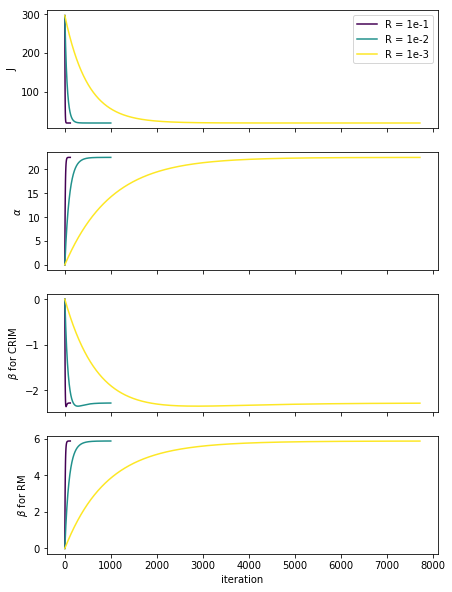

In [15]:
# the multivariate cost function
def multivariate_cost(xvalues, yvalues, alphas, betas):
    
    costs = np.zeros(len(alphas))
    
    for i in range(len(alphas)):
        cost = (1/(2*len(yvalues))) * np.sum((alphas[i] + np.sum(betas[i]*xvalues, axis=1) - yvalues)**2)
        costs[i] = cost
    
    return costs

# plot
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(7,10))

# colormap
colors = plt.cm.viridis(np.linspace(0,1,3))

ax[0].plot(np.arange(len(alphas_1)), multivariate_cost(X, Y, alphas_1, betas_1), c=colors[0], label='R = 1e-1')
ax[0].plot(np.arange(len(alphas_2)), multivariate_cost(X, Y, alphas_2, betas_2), c=colors[1], label='R = 1e-2')
ax[0].plot(np.arange(len(alphas_3)), multivariate_cost(X, Y, alphas_3, betas_3), c=colors[2], label='R = 1e-3')
ax[0].legend()
ax[0].set_ylabel('J')

ax[1].plot(np.arange(len(alphas_1)), alphas_1, c=colors[0])
ax[1].plot(np.arange(len(alphas_2)), alphas_2, c=colors[1])
ax[1].plot(np.arange(len(alphas_3)), alphas_3, c=colors[2])
ax[1].set_ylabel('$\\alpha$')

ax[2].plot(np.arange(len(betas_1[:,0])), betas_1[:,0], c=colors[0])
ax[2].plot(np.arange(len(betas_2[:,0])), betas_2[:,0], c=colors[1])
ax[2].plot(np.arange(len(betas_3[:,0])), betas_3[:,0], c=colors[2])
ax[2].set_ylabel('$\\beta$ for CRIM')

ax[3].plot(np.arange(len(betas_1[:,1])), betas_1[:,1], c=colors[0])
ax[3].plot(np.arange(len(betas_2[:,1])), betas_2[:,1], c=colors[1])
ax[3].plot(np.arange(len(betas_3[:,1])), betas_3[:,1], c=colors[2])
ax[3].set_ylabel('$\\beta$ for RM')
ax[3].set_xlabel('iteration')

plt.show(fig)

> <font color='red'>As we can see from the output above, all three tested R's end up with approximately the same estimated coefficients. This is in contrast to the results of part 2.1, which ended up with significantly different coefficients depending on the choice of R (see below).</font>

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [16]:
# pull out X and Y
X = boston[['CRIM','RM']].values.copy()
Y = boston['MEDV'].values.copy()

# initial alpha, beta
alpha_i = 0
beta_i = np.array([0,0])

# try R = 1e-1
alpha_1, beta_1, alphas_1, betas_1, total_time, iterations = multivariate_ols(X, Y, alpha_i, beta_i,
                                                                              R=1e-1, epsilon=1e-5,
                                                                              MaxIts=100000)
print('R = 1e-1')
print('alpha      = {:.2f}'.format(alpha_1))
print('beta       = {:.2f}, {:.2f}'.format(beta_1[0], beta_1[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# try R = 1e-2
alpha_2, beta_2, alphas_2, betas_2, total_time, iterations = multivariate_ols(X, Y, alpha_i, beta_i,
                                                                              R=1e-2, epsilon=1e-5,
                                                                              MaxIts=100000)
print('R = 1e-2')
print('alpha      = {:.2f}'.format(alpha_2))
print('beta       = {:.2f}, {:.2f}'.format(beta_2[0], beta_2[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# try R = 1e-3
alpha_3, beta_3, alphas_3, betas_3, total_time, iterations = multivariate_ols(X, Y, alpha_i, beta_i,
                                                                              R=1e-3, epsilon=1e-5,
                                                                              MaxIts=100000)
print('R = 1e-3')
print('alpha      = {:.2f}'.format(alpha_3))
print('beta       = {:.2f}, {:.2f}'.format(beta_3[0], beta_3[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

/Users/yuempark/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in subtract


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! max iterations reached !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
R = 1e-1
alpha      = nan
beta       = nan, nan
time       = 15.60s
iterations = 100000

R = 1e-2
alpha      = -29.16
beta       = -0.27, 8.38
time       = 6.14s
iterations = 51862

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! max iterations reached !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
R = 1e-3
alpha      = -19.52
beta       = -0.30, 6.88
time       = 15.09s
iterations = 100000



> <font color='red'>As we can see, if we do not use standardized variables, the model is far less stable. For R = 1e-1, the model diverged until an overflow was encountered, and the estimated coefficients were substantially different for R = 1e-2 and 1e-3. Furthermore, in all cases the model took far longer to converge, and in the case of R = 1e-3, the model failed to converge before reaching the maximum iteration limit. This illustrates the importance of standardizing the variables prior to implementing the gradient descent.
>
> I note that changing $\epsilon$ and R would help with allowing the model to converge better/faster for this particular set of unstandardized variables. However, if we changed the unstandardized variables in our model, we would need to significantly "re-tune" $\epsilon$ and $R$ for the new variables, and thus this approach is not a robust one.</font>

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Make sure to first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that in one of two ways. If you're feeling confident, use k-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for CRIM and RM). Or if you want to do the quick and dirty version, randomly divide your data into a training set (66%) and testing set (34%) and use the training set to re-fit the regression from 2.3 above. 

*NOTE: * If using k-fold cross-validation, you will end up with a different set of parameters for each fold. In this case, use the parameters from the fold that has the highest test performance.

> <font color='red'>I opt to use the training and testing set approach with R = 1e-3:</font>

In [17]:
# split into training and testing
train, test = train_test_split(boston, test_size=0.34, random_state=22)

# pull out X and Y from the training set - standardized
X_train = standardize(train[['CRIM','RM']].values.copy())
Y_train = train['MEDV'].values.copy()

# initial alpha, beta
alpha_i = 0
beta_i = np.array([0,0])

# use R = 1e-3
alpha_train, beta_train, alphas_train, betas_train, total_time, iterations = multivariate_ols(X_train, Y_train,
                                                                                              alpha_i, beta_i,
                                                                                              R=1e-3, epsilon=1e-5,
                                                                                              MaxIts=100000)
print('R = 1e-3')
print('alpha      = {:.2f}'.format(alpha_train))
print('beta       = {:.2f}, {:.2f}'.format(beta_train[0], beta_train[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

R = 1e-3
alpha      = 22.24
beta       = -2.08, 5.32
time       = 0.54s
iterations = 7705



> <font color='red'>When fitting on the entire dataset with R = 1e-3 (as in part 2.3), I obtained $\alpha$ = 22.52, $\beta_{1}$ = -2.28, and $\beta_{2}$ = 5.89. As we can see, these coefficients are similar, but slightly different, from the coefficients obtained when fitting on the training dataset only.</font>

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the RMSE on your test cases, i.e. take the model parameters that you found above, predict the values for just the test instances, and compare the actual to the predicted values. If you did this the k-fold way above, this will be the average RMSE across the k test sets. If you did this the quick and dirty way above, this will just be the RMSE on your single test set.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?

> <font color='red'>The RMSE function I wrote from problem set 3:</font>

In [18]:
def compute_rmse(predictions, yvalues):
    """
    Function
    --------
    Given two arrays, one of actual values and one of predicted values,
    compute the Root Mean Squared Error

    Parameters
    ----------
    predictions : array
        Array of numerical values corresponding to predictions for each of the N observations

    yvalues : array
        Array of numerical values corresponding to the actual values for each of the N observations

    Returns
    -------
    rmse : float
        Root Mean Squared Error of the prediction

    Example
    -------
    >>> print(compute_rmse((2,2,3),(0,2,6)))
    2.08
    """
    # check type of input, and convert to array if necessary
    if type(predictions)!=np.ndarray:
        predictions = np.array(predictions)
    if type(yvalues)!=np.ndarray:
        yvalues = np.array(yvalues)
    
    # do the computation
    rmse = np.sqrt(np.sum((predictions - yvalues)**2)/len(predictions))
    return rmse

In [19]:
# pull out X and Y from the testing set - standardized
X_test = standardize(test[['CRIM','RM']].values.copy())
Y_test = test['MEDV'].values.copy()

# predict Y with the coefficients
Y_test_predict = alpha_train + beta_train[0]*X_test[:,0] + beta_train[1]*X_test[:,1]

# compute RMSE
test_RMSE = compute_rmse(Y_test_predict, Y_test)

print('RMSE = {:.2f}'.format(test_RMSE))

RMSE = 6.22


> <font color='red'>The forward selection K nearest neighbours algorithm that I wrote in problem set 3 managed to achieve a RMSE of 3.15 using 9 features and K = 2. This is significantly better than the RMSE achieved above. However, at this point in the problem set, we are limiting our gradient descent model to two features (`CRIM` and `RM`), so the RMSE achieved here is not necessarily reflective of the best RMSE that could be achieved with the gradient descent model (i.e. we could add more features to improve the RMSE).</font>

### Extra Credit 1: Logistic Regression

For extra credit, implement logistic regression using gradient descent. Create a new variable (EXPENSIVE) to indicate whether the median housing price is more than $40,000. Use your model  a logistic regression of EXPENSIVE on CHAS and RM. Report your results.

> <font color='red'>The logistic regression equation:
>
> $$
P(Y_{i}=1) = \frac{1}{1+e^{-(\alpha + \beta_{1}X_{1i} + \beta_{2}X_{2i})}}
$$
>
> The cost function is:
>
>$$
J(\alpha, \beta_{1}, \beta_{2}) = -\frac{1}{N}\sum^{N}_{i=1}(Y_{i} \times \log P + (1 - Y_{i}) \times \log(1 - P))
$$
> 
> The associated gradient descent algorithm for each iteration is:
>
> $$
\alpha_{new} = \alpha + R \frac{1}{N}\sum^{N}_{i=1}(Y_{i} - \frac{1}{1 + e^{-(\alpha + \beta_{1}X_{1i} + \beta_{2}X_{2i})}})
$$
>
> $$
\beta_{1-new} = \beta_{1} + R \frac{1}{N}\sum^{N}_{i=1}(Y_{i} - \frac{1}{1 + e^{-(\alpha + \beta_{1}X_{1i} + \beta_{2}X_{2i})}})X_{1i}
$$
>
> $$
\beta_{2-new} = \beta_{2} + R \frac{1}{N}\sum^{N}_{i=1}(Y_{i} - \frac{1}{1 + e^{-(\alpha + \beta_{1}X_{1i} + \beta_{2}X_{2i})}})X_{2i}
$$
</font>

In [20]:
def logreg(xvalues, yvalues, alpha_i, betas_i, R, epsilon, MaxIts):
    """
    Gradient Decent to minimize logistic regression.

    Parameters
    ----------
    xvalues : narray - COLUMN VECTOR
        independent variable
        
    yvalues : narray - ROW VECTOR
        dependent variable
        
    alpha_i : float
        initial alpha
        
    beta_i : array - ROW VECTOR
        initial betas

    R : float
        Learning rate
        
    epsilon : float
        Convergence threshold

    MaxIts : Int
        maximum number of iterations

    Returns
    -------
    alpha : float
        intercept

    beta : array
        coefficients
        
    alphas : array
        each alpha that was stepped through
        
    betas : array
        each beta that was stepped through
        
    total_time : float
        running time in seconds
        
    iterations : int
        number of iterations to achieve convergence
    """
    # start the stopwatch
    start_time = time.time()
    
    # storage vectors
    alphas = np.array([alpha_i])
    betas = np.array([beta_i])
    
    # initialize coefficients
    alpha = alpha_i
    beta = beta_i
    N = len(yvalues)
    
    # loop until the max iterations
    for i in range(MaxIts):
        
        # compute new coefficients
        new_alpha = alpha + ((R/N) * np.sum(yvalues - (1/(1 + np.exp(-(alpha + np.sum(beta*xvalues, axis=1)))))))
        new_beta = beta + ((R/N) *\
                   np.sum(yvalues - (1/(1 + np.exp(-(alpha + np.sum(beta*xvalues, axis=1)))))*(xvalues.T), axis=1))
        
        # store
        alphas = np.append(alphas, new_alpha)
        betas = np.append(betas, np.array([new_beta]), axis=0)
        
        # check to see whether stopping criteria has been met
        if (np.abs(new_alpha-alpha)<epsilon) and np.all(np.abs(new_beta-beta)<epsilon):
            alpha = new_alpha
            beta = new_beta
            break
        else:
            alpha = new_alpha
            beta = new_beta
    
    # iterations - print warning message if max iterations reached
    iterations = i+1
    if iterations==MaxIts:
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print('!!! max iterations reached !!!')
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

    # stop the stopwatch
    end_time = time.time()
    total_time = end_time - start_time
    
    return alpha, beta, alphas, betas, total_time, iterations

> <font color='red'>Do the gradient descent:</font>

In [21]:
# pull out X and Y
X = standardize(boston[['CHAS','RM']].values.copy())
Y = boston['MEDV'].values.copy()

# change Y to be binary
Y[Y<=40] = 0
Y[Y>40] = 1

# initial alpha, beta
alpha_i = 0
beta_i = np.array([0,0])

# try R = 1e-1
alpha_1, beta_1, alphas_1, betas_1, total_time, iterations = logreg(X, Y, alpha_i, beta_i,
                                                                    R=1e-1, epsilon=1e-5,
                                                                    MaxIts=100000)
print('R = 1e-1')
print('alpha      = {:.2f}'.format(alpha_1))
print('beta       = {:.2f}, {:.2f}'.format(beta_1[0], beta_1[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# try R = 1e-2
alpha_2, beta_2, alphas_2, betas_2, total_time, iterations = logreg(X, Y, alpha_i, beta_i,
                                                                    R=1e-2, epsilon=1e-5,
                                                                    MaxIts=100000)
print('R = 1e-2')
print('alpha      = {:.2f}'.format(alpha_2))
print('beta       = {:.2f}, {:.2f}'.format(beta_2[0], beta_2[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# try R = 1e-3
alpha_3, beta_3, alphas_3, betas_3, total_time, iterations = logreg(X, Y, alpha_i, beta_i,
                                                                    R=1e-3, epsilon=1e-5,
                                                                    MaxIts=100000)
print('R = 1e-3')
print('alpha      = {:.2f}'.format(alpha_3))
print('beta       = {:.2f}, {:.2f}'.format(beta_3[0], beta_3[1]))
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

R = 1e-1
alpha      = -3.25
beta       = 0.51, 0.87
time       = 0.23s
iterations = 2186

R = 1e-2
alpha      = -3.21
beta       = 0.50, 0.85
time       = 1.43s
iterations = 12793

R = 1e-3
alpha      = -2.92
beta       = 0.45, 0.70
time       = 6.60s
iterations = 47615



> <font color='red'>Plot how the cost function, $\alpha$, and $\beta$ are changing with each iteration:</font>

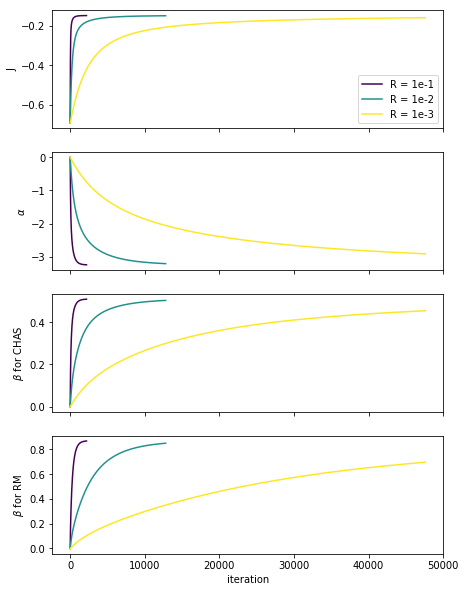

In [22]:
# the logreg cost function
def logreg_cost(xvalues, yvalues, alphas, betas):
    
    costs = np.zeros(len(alphas))
    
    for i in range(len(alphas)):
        P = 1 / (1 + np.exp(-(alphas[i] + np.sum(betas[i]*xvalues, axis=1))))
        cost = -(1/len(yvalues)) * np.sum(-yvalues * np.log(P) - (1 - yvalues) * np.log(1-P))
        costs[i] = cost
    
    return costs

# plot
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(7,10))

# colormap
colors = plt.cm.viridis(np.linspace(0,1,3))

ax[0].plot(np.arange(len(alphas_1)), logreg_cost(X, Y, alphas_1, betas_1), c=colors[0], label='R = 1e-1')
ax[0].plot(np.arange(len(alphas_2)), logreg_cost(X, Y, alphas_2, betas_2), c=colors[1], label='R = 1e-2')
ax[0].plot(np.arange(len(alphas_3)), logreg_cost(X, Y, alphas_3, betas_3), c=colors[2], label='R = 1e-3')
ax[0].legend()
ax[0].set_ylabel('J')

ax[1].plot(np.arange(len(alphas_1)), alphas_1, c=colors[0])
ax[1].plot(np.arange(len(alphas_2)), alphas_2, c=colors[1])
ax[1].plot(np.arange(len(alphas_3)), alphas_3, c=colors[2])
ax[1].set_ylabel('$\\alpha$')

ax[2].plot(np.arange(len(betas_1[:,0])), betas_1[:,0], c=colors[0])
ax[2].plot(np.arange(len(betas_2[:,0])), betas_2[:,0], c=colors[1])
ax[2].plot(np.arange(len(betas_3[:,0])), betas_3[:,0], c=colors[2])
ax[2].set_ylabel('$\\beta$ for CHAS')

ax[3].plot(np.arange(len(betas_1[:,1])), betas_1[:,1], c=colors[0])
ax[3].plot(np.arange(len(betas_2[:,1])), betas_2[:,1], c=colors[1])
ax[3].plot(np.arange(len(betas_3[:,1])), betas_3[:,1], c=colors[2])
ax[3].set_ylabel('$\\beta$ for RM')
ax[3].set_xlabel('iteration')

plt.show(fig)

> <font color='red'>Plot the probability surface, along with the data, for R = 1e-1:</font>

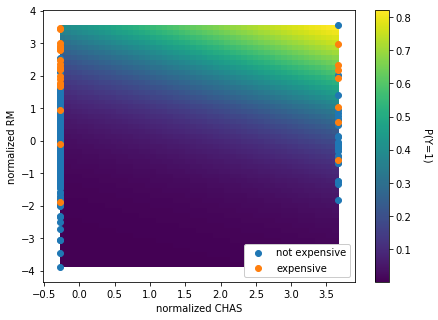

In [23]:
# calculate the probability surface
X_plot = (np.linspace(np.min(X[:,0]), np.max(X[:,0])))
Y_plot = (np.linspace(np.min(X[:,1]), np.max(X[:,1])))
X_plot, Y_plot = np.meshgrid(X_plot, Y_plot)
Z_plot = 1 / (1 + np.exp(-(alpha_1 + beta_1[0]*X_plot + beta_1[1]*Y_plot)))

fig, ax = plt.subplots(figsize=(7,5))

# plot
im = ax.pcolormesh(X_plot, Y_plot, Z_plot, cmap='viridis')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('P(Y=1)', rotation=270, labelpad=20)

ax.scatter(X[Y==0][:,0], X[Y==0][:,1], c='C0', label='not expensive')
ax.scatter(X[Y==1][:,0], X[Y==1][:,1], c='C1', label='expensive')

# prettify
ax.set_xlabel('normalized CHAS')
ax.set_ylabel('normalized RM')
ax.legend(framealpha=1)

plt.show(fig)

> <font color='red'>As we can see from above, the logistic regression creates a probability surface for predicting whether a neighbourhood is expensive or not. Qualitatively, the surface computed here predicts that neighbourhoods that are on the Charles River and have lots of rooms are more likely to be expensive. Clearly, however, this surface fails to predict certain outliers.
>
> I note, however, that I may have dealt with the binary variable `CHAS` in a non-ideal fashion... should binary variables be standardized along with the continuous variables? Or should they be left as binary?</font>

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features. If you originally had *K* features, you should now have K+(K*(K+1))/2 features. Standardize all of your features.

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [24]:
# start a new dataframe without 'MEDV'
bdata = load_boston()
boston = pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names[:]

# create the interaction variables
n_cols = len(boston.columns)
for i in range(n_cols):
    for j in range(i, n_cols):
        col_name = boston.columns[i] + '_' + boston.columns[j]
        boston[col_name] = boston[boston.columns[i]] * boston[boston.columns[j]]
        
print(len(boston.columns))

104


In [25]:
# add 'MEDV' back to the dataframe
boston['MEDV'] = bdata.target

# split into training and testing
train, test = train_test_split(boston, test_size=0.34, random_state=22)

### 4.2 Overfitting (sort of)
Now, using your version of multivariate regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those K+(K*(K+1))/2 features as you can (Don't forget to add quadratic terms. Form instance, RM^2.).  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

> <font color='red'>I run two versions below - the first uses all the 13 variables in the original dataset (i.e. no interaction variables), and the second uses 10 pseudo-randomly selected interaction variables. In both cases, I use R = 1e-3:</font>

In [26]:
# pull out X and Y from the training set - standardized
X_train = standardize(train[['CRIM',
                             'ZN',
                             'INDUS',
                             'CHAS',
                             'NOX',
                             'RM',
                             'AGE',
                             'DIS',
                             'RAD',
                             'TAX',
                             'PTRATIO',
                             'B',
                             'LSTAT']].values.copy())
Y_train = train['MEDV'].values.copy()

# initial alpha, beta
alpha_i = 0
beta_i = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])

# use R = 1e-3
alpha_train, beta_train, alphas_train, betas_train, total_time, iterations = multivariate_ols(X_train, Y_train,
                                                                                              alpha_i, beta_i,
                                                                                              R=1e-3, epsilon=1e-5,
                                                                                              MaxIts=100000)
print('R = 1e-3')
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# pull out X and Y from the testing set - standardized
X_test = standardize(test[['CRIM',
                           'ZN',
                           'INDUS',
                           'CHAS',
                           'NOX',
                           'RM',
                           'AGE',
                           'DIS',
                           'RAD',
                           'TAX',
                           'PTRATIO',
                           'B',
                           'LSTAT']].values.copy())
Y_test = test['MEDV'].values.copy()

# predict Y with the coefficients
Y_train_predict = alpha_train +\
                  beta_train[0]*X_train[:,0] +\
                  beta_train[1]*X_train[:,1] +\
                  beta_train[2]*X_train[:,2] +\
                  beta_train[3]*X_train[:,3] +\
                  beta_train[4]*X_train[:,4] +\
                  beta_train[5]*X_train[:,5] +\
                  beta_train[6]*X_train[:,6] +\
                  beta_train[7]*X_train[:,7] +\
                  beta_train[8]*X_train[:,8] +\
                  beta_train[9]*X_train[:,9] +\
                  beta_train[10]*X_train[:,10] +\
                  beta_train[11]*X_train[:,11] +\
                  beta_train[12]*X_train[:,12]
Y_test_predict = alpha_train +\
                 beta_train[0]*X_test[:,0] +\
                 beta_train[1]*X_test[:,1] +\
                 beta_train[2]*X_test[:,2] +\
                 beta_train[3]*X_test[:,3] +\
                 beta_train[4]*X_test[:,4] +\
                 beta_train[5]*X_test[:,5] +\
                 beta_train[6]*X_test[:,6] +\
                 beta_train[7]*X_test[:,7] +\
                 beta_train[8]*X_test[:,8] +\
                 beta_train[9]*X_test[:,9] +\
                 beta_train[10]*X_test[:,10] +\
                 beta_train[11]*X_test[:,11] +\
                 beta_train[12]*X_test[:,12]

# compute RMSE
train_RMSE = compute_rmse(Y_train_predict, Y_train)
test_RMSE = compute_rmse(Y_test_predict, Y_test)

print('train RMSE = {:.2f}'.format(train_RMSE))
print('test  RMSE = {:.2f}'.format(test_RMSE))

R = 1e-3
time       = 13.43s
iterations = 42704

train RMSE = 4.69
test  RMSE = 4.88


In [27]:
# pull out X and Y from the training set - standardized
X_train = standardize(train[['ZN_AGE',
                             'INDUS_B',
                             'RAD_LSTAT',
                             'CRIM_DIS',
                             'INDUS_PTRATIO',
                             'AGE_AGE',
                             'B_LSTAT',
                             'CHAS_DIS',
                             'PTRATIO_B',
                             'ZN_TAX']].values.copy())
Y_train = train['MEDV'].values.copy()

# initial alpha, beta
alpha_i = 0
beta_i = np.array([0,0,0,0,0,0,0,0,0,0])

# use R = 1e-3
alpha_train, beta_train, alphas_train, betas_train, total_time, iterations = multivariate_ols(X_train, Y_train,
                                                                                              alpha_i, beta_i,
                                                                                              R=1e-3, epsilon=1e-5,
                                                                                              MaxIts=100000)
print('R = 1e-3')
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# pull out X and Y from the testing set - standardized
X_test = standardize(test[['ZN_AGE',
                           'INDUS_B',
                           'RAD_LSTAT',
                           'CRIM_DIS',
                           'INDUS_PTRATIO',
                           'AGE_AGE',
                           'B_LSTAT',
                           'CHAS_DIS',
                           'PTRATIO_B',
                           'ZN_TAX']].values.copy())
Y_test = test['MEDV'].values.copy()

# predict Y with the coefficients
Y_train_predict = alpha_train +\
                  beta_train[0]*X_train[:,0] +\
                  beta_train[1]*X_train[:,1] +\
                  beta_train[2]*X_train[:,2] +\
                  beta_train[3]*X_train[:,3] +\
                  beta_train[4]*X_train[:,4] +\
                  beta_train[5]*X_train[:,5] +\
                  beta_train[6]*X_train[:,6] +\
                  beta_train[7]*X_train[:,7] +\
                  beta_train[8]*X_train[:,8] +\
                  beta_train[9]*X_train[:,9]
Y_test_predict = alpha_train +\
                 beta_train[0]*X_test[:,0] +\
                 beta_train[1]*X_test[:,1] +\
                 beta_train[2]*X_test[:,2] +\
                 beta_train[3]*X_test[:,3] +\
                 beta_train[4]*X_test[:,4] +\
                 beta_train[5]*X_test[:,5] +\
                 beta_train[6]*X_test[:,6] +\
                 beta_train[7]*X_test[:,7] +\
                 beta_train[8]*X_test[:,8] +\
                 beta_train[9]*X_test[:,9]

# compute RMSE
train_RMSE = compute_rmse(Y_train_predict, Y_train)
test_RMSE = compute_rmse(Y_test_predict, Y_test)

print('train RMSE = {:.2f}'.format(train_RMSE))
print('test  RMSE = {:.2f}'.format(test_RMSE))

R = 1e-3
time       = 37.27s
iterations = 80021

train RMSE = 5.56
test  RMSE = 6.01


> <font color='red'>As we can see from the results above, by including many variables in our regression, we generally obtain a lower RMSE than if we have fewer variables. This can be explained by overfitting. Furthermore, we consistently achieve a lower RMSE on the test data than on the training data.
>
> The RMSE's achieved here are better than that achieved in part 3.2 (6.22), but still worse than that achieved in K nearest neighbours (3.15). The addition of more variables allows us to achieve a better RMSE than in part 3.2, which only used two features. However, we achieve a worse RMSE than that achieved in K nearest neighbours, despite having more included features in the method used here, because the K nearest neighbours used a forward selection technique to choose the "best" combination of nine features to predict `MEDV`, instead of a random combination of features.</font>

### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model from 4.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

Go brag to your friends about how you just implemented ridge-regularized multivariate regression using gradient descent optimization, from scratch. If you still have friends.

> <font color='red'>The cost function with ridge regularization is:
>
>$$
J(\alpha, \beta_{1}, ..., \beta_{k}) = \frac{1}{2N}\sum^{N}_{i=1}(\alpha + \beta_{1}X_{i1} + ... + \beta_{k}X_{ik} - Y_{i})^{2} + \lambda\sum^{k}_{j=1}\beta_{k}^{2}
$$
> 
> The associated gradient descent algorithm for each iteration is:
>
> $$
\alpha_{new} = \alpha - R \frac{1}{N}\sum^{N}_{i=1}(\alpha + \beta_{1}X_{i1} + ... + \beta_{k}X_{ik} - Y_{i})
$$
>
> $$
\beta_{j-new} = \beta_{j}(1 - R\frac{\lambda}{N}) - R \frac{1}{N}\sum^{N}_{i=1}(\alpha + \beta_{1}X_{i1} + ... + \beta_{k}X_{ik} - Y_{i})X_{ij}
$$
</font>

In [28]:
def multivariate_ridge_ols(xvalues, yvalues, alpha_i, betas_i, R, epsilon, lamb, MaxIts):
    """
    Gradient Decent to minimize OLS, with ridge regularization.

    Parameters
    ----------
    xvalues : narray - COLUMN VECTOR
        independent variable
        
    yvalues : narray - ROW VECTOR
        dependent variable
        
    alpha_i : float
        initial alpha
        
    beta_i : array - ROW VECTOR
        initial betas

    R : float
        Learning rate
        
    epsilon : float
        Convergence threshold
        
    lamb : float
        lambda for regularization

    MaxIts : Int
        maximum number of iterations

    Returns
    -------
    alpha : float
        intercept

    beta : array
        coefficients
        
    alphas : array
        each alpha that was stepped through
        
    betas : array
        each beta that was stepped through
        
    total_time : float
        running time in seconds
        
    iterations : int
        number of iterations to achieve convergence
    """
    # start the stopwatch
    start_time = time.time()
    
    # storage vectors
    alphas = np.array([alpha_i])
    betas = np.array([beta_i])
    
    # initialize coefficients
    alpha = alpha_i
    beta = beta_i
    N = len(yvalues)
    
    # loop until the max iterations
    for i in range(MaxIts):
        
        # compute new coefficients
        new_alpha = alpha - ((R/N) * np.sum(alpha + np.sum(beta*xvalues, axis=1) - yvalues))
        new_beta = (beta*(1-(R*(lamb/N)))) - \
                   ((R/N) * np.sum((alpha + np.sum(beta*xvalues, axis=1) - yvalues)*(xvalues.T), axis=1))
        
        # store
        alphas = np.append(alphas, new_alpha)
        betas = np.append(betas, np.array([new_beta]), axis=0)
        
        # check to see whether stopping criteria has been met
        if (np.abs(new_alpha-alpha)<epsilon) and np.all(np.abs(new_beta-beta)<epsilon):
            alpha = new_alpha
            beta = new_beta
            break
        else:
            alpha = new_alpha
            beta = new_beta
    
    # iterations - print warning message if max iterations reached
    iterations = i+1
    if iterations==MaxIts:
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print('!!! max iterations reached !!!')
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

    # stop the stopwatch
    end_time = time.time()
    total_time = end_time - start_time
    
    return alpha, beta, alphas, betas, total_time, iterations

> <font color='red'>Now do the gradient descent with ridge regularization. I test $\lambda$ = 1, 10, 100. For all cases, I use the original 13 features, and R = 1e-3.</font>

In [29]:
# pull out X and Y from the training set - standardized
X_train = standardize(train[['CRIM',
                             'ZN',
                             'INDUS',
                             'CHAS',
                             'NOX',
                             'RM',
                             'AGE',
                             'DIS',
                             'RAD',
                             'TAX',
                             'PTRATIO',
                             'B',
                             'LSTAT']].values.copy())
Y_train = train['MEDV'].values.copy()

# pull out X and Y from the testing set - standardized
X_test = standardize(test[['CRIM',
                           'ZN',
                           'INDUS',
                           'CHAS',
                           'NOX',
                           'RM',
                           'AGE',
                           'DIS',
                           'RAD',
                           'TAX',
                           'PTRATIO',
                           'B',
                           'LSTAT']].values.copy())
Y_test = test['MEDV'].values.copy()

# initial alpha, beta
alpha_i = 0
beta_i = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])

# use R = 1e-3, lambda = 1
alpha_1,beta_1,alphas_1,betas_1,total_time,iterations = multivariate_ridge_ols(X_train, Y_train,
                                                                               alpha_i, beta_i,
                                                                               R=1e-3, epsilon=1e-5,
                                                                               lamb=1,
                                                                               MaxIts=100000)
print('lambda = 1')
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# predict Y with the coefficients
Y_train_predict = alpha_1 +\
                  beta_1[0]*X_train[:,0] +\
                  beta_1[1]*X_train[:,1] +\
                  beta_1[2]*X_train[:,2] +\
                  beta_1[3]*X_train[:,3] +\
                  beta_1[4]*X_train[:,4] +\
                  beta_1[5]*X_train[:,5] +\
                  beta_1[6]*X_train[:,6] +\
                  beta_1[7]*X_train[:,7] +\
                  beta_1[8]*X_train[:,8] +\
                  beta_1[9]*X_train[:,9] +\
                  beta_1[10]*X_train[:,10] +\
                  beta_1[11]*X_train[:,11] +\
                  beta_1[12]*X_train[:,12]
Y_test_predict = alpha_1 +\
                 beta_1[0]*X_test[:,0] +\
                 beta_1[1]*X_test[:,1] +\
                 beta_1[2]*X_test[:,2] +\
                 beta_1[3]*X_test[:,3] +\
                 beta_1[4]*X_test[:,4] +\
                 beta_1[5]*X_test[:,5] +\
                 beta_1[6]*X_test[:,6] +\
                 beta_1[7]*X_test[:,7] +\
                 beta_1[8]*X_test[:,8] +\
                 beta_1[9]*X_test[:,9] +\
                 beta_1[10]*X_test[:,10] +\
                 beta_1[11]*X_test[:,11] +\
                 beta_1[12]*X_test[:,12]

# compute RMSE
train_RMSE = compute_rmse(Y_train_predict, Y_train)
test_RMSE = compute_rmse(Y_test_predict, Y_test)

print('train RMSE = {:.2f}'.format(train_RMSE))
print('test  RMSE = {:.2f}'.format(test_RMSE))

lambda = 1
time       = 12.94s
iterations = 40635

train RMSE = 4.69
test  RMSE = 4.88


In [30]:
# initial alpha, beta
alpha_i = 0
beta_i = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])

# use R = 1e-3, lambda = 10
alpha_2,beta_2,alphas_2,betas_2,total_time,iterations = multivariate_ridge_ols(X_train, Y_train,
                                                                               alpha_i, beta_i,
                                                                               R=1e-3, epsilon=1e-5,
                                                                               lamb=10,
                                                                               MaxIts=100000)
print('lambda = 10')
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# predict Y with the coefficients
Y_train_predict = alpha_2 +\
                  beta_2[0]*X_train[:,0] +\
                  beta_2[1]*X_train[:,1] +\
                  beta_2[2]*X_train[:,2] +\
                  beta_2[3]*X_train[:,3] +\
                  beta_2[4]*X_train[:,4] +\
                  beta_2[5]*X_train[:,5] +\
                  beta_2[6]*X_train[:,6] +\
                  beta_2[7]*X_train[:,7] +\
                  beta_2[8]*X_train[:,8] +\
                  beta_2[9]*X_train[:,9] +\
                  beta_2[10]*X_train[:,10] +\
                  beta_2[11]*X_train[:,11] +\
                  beta_2[12]*X_train[:,12]
Y_test_predict = alpha_2 +\
                 beta_2[0]*X_test[:,0] +\
                 beta_2[1]*X_test[:,1] +\
                 beta_2[2]*X_test[:,2] +\
                 beta_2[3]*X_test[:,3] +\
                 beta_2[4]*X_test[:,4] +\
                 beta_2[5]*X_test[:,5] +\
                 beta_2[6]*X_test[:,6] +\
                 beta_2[7]*X_test[:,7] +\
                 beta_2[8]*X_test[:,8] +\
                 beta_2[9]*X_test[:,9] +\
                 beta_2[10]*X_test[:,10] +\
                 beta_2[11]*X_test[:,11] +\
                 beta_2[12]*X_test[:,12]

# compute RMSE
train_RMSE = compute_rmse(Y_train_predict, Y_train)
test_RMSE = compute_rmse(Y_test_predict, Y_test)

print('train RMSE = {:.2f}'.format(train_RMSE))
print('test  RMSE = {:.2f}'.format(test_RMSE))

lambda = 10
time       = 6.62s
iterations = 28085

train RMSE = 4.70
test  RMSE = 4.92


In [31]:
# initial alpha, beta
alpha_i = 0
beta_i = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])

# use R = 1e-3, lambda = 100
alpha_3,beta_3,alphas_3,betas_3,total_time,iterations = multivariate_ridge_ols(X_train, Y_train,
                                                                               alpha_i, beta_i,
                                                                               R=1e-3, epsilon=1e-5,
                                                                               lamb=100,
                                                                               MaxIts=100000)
print('lambda = 100')
print('time       = {:.2f}s'.format(total_time))
print('iterations = {}'.format(iterations))
print('')

# predict Y with the coefficients
Y_train_predict = alpha_3 +\
                  beta_3[0]*X_train[:,0] +\
                  beta_3[1]*X_train[:,1] +\
                  beta_3[2]*X_train[:,2] +\
                  beta_3[3]*X_train[:,3] +\
                  beta_3[4]*X_train[:,4] +\
                  beta_3[5]*X_train[:,5] +\
                  beta_3[6]*X_train[:,6] +\
                  beta_3[7]*X_train[:,7] +\
                  beta_3[8]*X_train[:,8] +\
                  beta_3[9]*X_train[:,9] +\
                  beta_3[10]*X_train[:,10] +\
                  beta_3[11]*X_train[:,11] +\
                  beta_3[12]*X_train[:,12]
Y_test_predict = alpha_3 +\
                 beta_3[0]*X_test[:,0] +\
                 beta_3[1]*X_test[:,1] +\
                 beta_3[2]*X_test[:,2] +\
                 beta_3[3]*X_test[:,3] +\
                 beta_3[4]*X_test[:,4] +\
                 beta_3[5]*X_test[:,5] +\
                 beta_3[6]*X_test[:,6] +\
                 beta_3[7]*X_test[:,7] +\
                 beta_3[8]*X_test[:,8] +\
                 beta_3[9]*X_test[:,9] +\
                 beta_3[10]*X_test[:,10] +\
                 beta_3[11]*X_test[:,11] +\
                 beta_3[12]*X_test[:,12]

# compute RMSE
train_RMSE = compute_rmse(Y_train_predict, Y_train)
test_RMSE = compute_rmse(Y_test_predict, Y_test)

print('train RMSE = {:.2f}'.format(train_RMSE))
print('test  RMSE = {:.2f}'.format(test_RMSE))

lambda = 100
time       = 1.06s
iterations = 7725

train RMSE = 4.96
test  RMSE = 5.27


> <font color='red'>As we can see from the results above, increasing $\lambda$ from 1 to 10 to 100 while keeping everything else in the model the same (i.e. the number of features, R, etc.) results in a small increase in RMSE for both the training and testing datasets. See the discussion in extra credit 2 below for a further discussion of the effect of changing $\lambda$.
>
> As in part 4.2, this means that the RMSE's achieved here are better than that achieved in part 3.2 (6.22), but still worse than that achieved in K nearest neighbours (3.15).</font>

### Extra Credit 2: Cross-validate lambda

Use k-fold cross-validation to select the optimal value of lambda. Report the average RMSE across all training sets, and the average RMSE across all testing sets. How do these numbers compare to each other, to the RMSE from your previous efforts?  Finally, create a scatter plot that shows RMSE as a function of lambda.

> <font color='red'>Here I use 5 fold cross validation (to decrease computational cost) and test $\lambda$ between 1 and 100. As in part 4.3, I use the original 13 variables, and keep R = 1e-3 in all cases:</font>

In [32]:
# reload the boston dataframe (without the interaction terms)
bdata = load_boston()
boston = pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names[:]
boston['MEDV'] = bdata.target

# get the X and Y
X = standardize(boston[['CRIM',
                        'ZN',
                        'INDUS',
                        'CHAS',
                        'NOX',
                        'RM',
                        'AGE',
                        'DIS',
                        'RAD',
                        'TAX',
                        'PTRATIO',
                        'B',
                        'LSTAT']].values.copy())
Y = boston['MEDV'].values.copy()

# set up the 5-fold cross validation, with a seed
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=22)

# get the training and testing indexes
train_inds = []
test_inds = []
for train_ind, test_ind in kf.split(X):
    train_inds.append(train_ind)
    test_inds.append(test_ind)

# lambdas to test
lambdas = np.linspace(1,100,10)

# storage vectors
training_RMSE = np.zeros(len(lambdas))
testing_RMSE = np.zeros(len(lambdas))
alphas = []
beta_0s = []
beta_1s = []
beta_2s = []
beta_3s = []
beta_4s = []
beta_5s = []
beta_6s = []
beta_7s = []
beta_8s = []
beta_9s = []
beta_10s = []
beta_11s = []
beta_12s = []

# iterate through lambdas
for i in range(len(lambdas)):
    
    split_training_RMSE = np.zeros(n_splits)
    split_testing_RMSE = np.zeros(n_splits)
    
    # iterate through folds
    for j in range(n_splits):
        
        # split
        X_train = X[train_inds[j]]
        Y_train = Y[train_inds[j]]
        X_test = X[test_inds[j]]
        Y_test = Y[test_inds[j]]
        
        # initial alpha, beta
        alpha_i = 0
        beta_i = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])
        
        # use R = 1e-3
        alpha_train,beta_train,alphas_train,betas_train,total_time,iterations=multivariate_ridge_ols(X_train,
                                                                                                     Y_train,
                                                                                                     alpha_i,
                                                                                                     beta_i,
                                                                                                     R=1e-3,
                                                                                                     epsilon=1e-5,
                                                                                                     lamb=lambdas[i],
                                                                                                     MaxIts=100000)
        
        # predict Y with the coefficients
        Y_train_predict = alpha_train +\
                          beta_train[0]*X_train[:,0] +\
                          beta_train[1]*X_train[:,1] +\
                          beta_train[2]*X_train[:,2] +\
                          beta_train[3]*X_train[:,3] +\
                          beta_train[4]*X_train[:,4] +\
                          beta_train[5]*X_train[:,5] +\
                          beta_train[6]*X_train[:,6] +\
                          beta_train[7]*X_train[:,7] +\
                          beta_train[8]*X_train[:,8] +\
                          beta_train[9]*X_train[:,9] +\
                          beta_train[10]*X_train[:,10] +\
                          beta_train[11]*X_train[:,11] +\
                          beta_train[12]*X_train[:,12]
        Y_test_predict = alpha_train +\
                         beta_train[0]*X_test[:,0] +\
                         beta_train[1]*X_test[:,1] +\
                         beta_train[2]*X_test[:,2] +\
                         beta_train[3]*X_test[:,3] +\
                         beta_train[4]*X_test[:,4] +\
                         beta_train[5]*X_test[:,5] +\
                         beta_train[6]*X_test[:,6] +\
                         beta_train[7]*X_test[:,7] +\
                         beta_train[8]*X_test[:,8] +\
                         beta_train[9]*X_test[:,9] +\
                         beta_train[10]*X_test[:,10] +\
                         beta_train[11]*X_test[:,11] +\
                         beta_train[12]*X_test[:,12]
        
        # compute RMSE
        split_training_RMSE[j] = compute_rmse(Y_train_predict, Y_train)
        split_testing_RMSE[j] = compute_rmse(Y_test_predict, Y_test)
        
        # store alphas and betas if it's the first fold
        if j==0:
            alphas.append(alpha_train)
            beta_0s.append(beta_train[0])
            beta_1s.append(beta_train[1])
            beta_2s.append(beta_train[2])
            beta_3s.append(beta_train[3])
            beta_4s.append(beta_train[4])
            beta_5s.append(beta_train[5])
            beta_6s.append(beta_train[6])
            beta_7s.append(beta_train[7])
            beta_8s.append(beta_train[8])
            beta_9s.append(beta_train[9])
            beta_10s.append(beta_train[10])
            beta_11s.append(beta_train[11])
            beta_12s.append(beta_train[12])
        
    # get the average over the splits and store
    training_RMSE[i] = np.mean(split_training_RMSE)
    testing_RMSE[i] = np.mean(split_testing_RMSE)

> <font color='red'>Plot:</font>

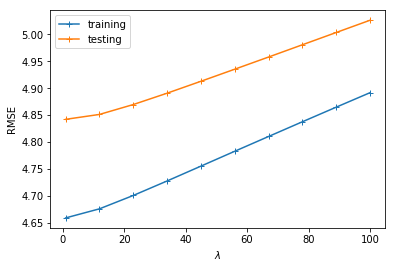

In [33]:
fig, ax = plt.subplots()

ax.plot(lambdas, training_RMSE, '+-', c='C0', label='training')
ax.plot(lambdas, testing_RMSE, '+-', c='C1', label='testing')

ax.set_xlabel('$\\lambda$')
ax.set_ylabel('RMSE')
ax.legend()

plt.show(fig)

> <font color='red'>As we can see from the plot above, the results here are similar to what was achieved in part 4.3: increasing $\lambda$ increases RMSE. It is not readily clear why this is the observed behaviour, but there are a few possibilities: first, it is possible that the features with the largest coefficients (which are getting penalized most heavily by the ridge regularization) are the strongest predictors for `MEDV`, and so increasing $\lambda$ is effectively decreasing the predictive power of the model. Second, it is possible that I just implemented the ridge regularization incorrectly... but I checked the code and math I couldn't seem to find a mistake.</font>

### (Showoff) Extra Credit 3: Lambda and coefficients

If you're feeling extra-special, create a parameter plot that shows how the different coefficient estimates change as a function of lambda. To make this graph intelligible, only include the *K* original F_s features in this plot

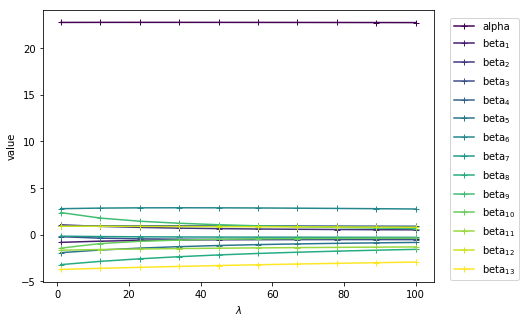

In [34]:
fig, ax = plt.subplots(figsize=(7,5))

# colormap
colors = plt.cm.viridis(np.linspace(0,1,14))

ax.plot(lambdas, alphas, '+-', c=colors[0], label='alpha')
ax.plot(lambdas, beta_0s, '+-', c=colors[1], label='beta$_{1}$')
ax.plot(lambdas, beta_1s, '+-', c=colors[2], label='beta$_{2}$')
ax.plot(lambdas, beta_2s, '+-', c=colors[3], label='beta$_{3}$')
ax.plot(lambdas, beta_3s, '+-', c=colors[4], label='beta$_{4}$')
ax.plot(lambdas, beta_4s, '+-', c=colors[5], label='beta$_{5}$')
ax.plot(lambdas, beta_5s, '+-', c=colors[6], label='beta$_{6}$')
ax.plot(lambdas, beta_6s, '+-', c=colors[7], label='beta$_{7}$')
ax.plot(lambdas, beta_7s, '+-', c=colors[8], label='beta$_{8}$')
ax.plot(lambdas, beta_8s, '+-', c=colors[9], label='beta$_{9}$')
ax.plot(lambdas, beta_9s, '+-', c=colors[10], label='beta$_{10}$')
ax.plot(lambdas, beta_10s, '+-', c=colors[11], label='beta$_{11}$')
ax.plot(lambdas, beta_11s, '+-', c=colors[12], label='beta$_{12}$')
ax.plot(lambdas, beta_12s, '+-', c=colors[13], label='beta$_{13}$')

ax.set_xlabel('$\\lambda$')
ax.set_ylabel('value')
ax.legend(loc='upper left', bbox_to_anchor=(1.03,0.99))

plt.show(fig)

> <font color='red'>As discussed in extra credit 2, we can see that the ridge regularization is generally penalizing the largest coefficients, and pushing them toward zero. $\alpha$ does not get penalized, since it is the intercept, but I am not sure why some of the larger $\beta$ coefficients (e.g. $\beta_{13}$) are not being penalized...</font>